In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from darts.metrics import mse, mae, rmse
from darts.models import ARIMA, ExponentialSmoothing, NaiveMean, NaiveMovingAverage, NaiveSeasonal, KalmanForecaster
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode
from darts.dataprocessing.transformers import Scaler, Diff

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [48]:
path_processed = "processed/tuntidata_processed.csv"

df_waste = pd.read_csv(path_processed, header=0)

df_waste.head(10)

,date,weekday,hour,datetime,quantity
0,2023-01-02,0,10,2023-01-02 10:00:00,18.0
1,2023-01-02,0,11,2023-01-02 11:00:00,83.0
2,2023-01-02,0,12,2023-01-02 12:00:00,79.0
3,2023-01-02,0,13,2023-01-02 13:00:00,90.0
4,2023-01-02,0,14,2023-01-02 14:00:00,1.0
5,2023-01-03,1,10,2023-01-03 10:00:00,26.0
6,2023-01-03,1,11,2023-01-03 11:00:00,88.0
7,2023-01-03,1,12,2023-01-03 12:00:00,94.0
8,2023-01-03,1,13,2023-01-03 13:00:00,108.0
9,2023-01-03,1,14,2023-01-03 14:00:00,10.0


In [49]:
df_hour12 = df_waste[df_waste['hour'] == 12]
df_hour12.head()

,date,weekday,hour,datetime,quantity
2,2023-01-02,0,12,2023-01-02 12:00:00,79.0
7,2023-01-03,1,12,2023-01-03 12:00:00,94.0
12,2023-01-04,2,12,2023-01-04 12:00:00,107.0
17,2023-01-05,3,12,2023-01-05 12:00:00,145.0
22,2023-01-09,0,12,2023-01-09 12:00:00,163.0


<Axes: xlabel='date'>

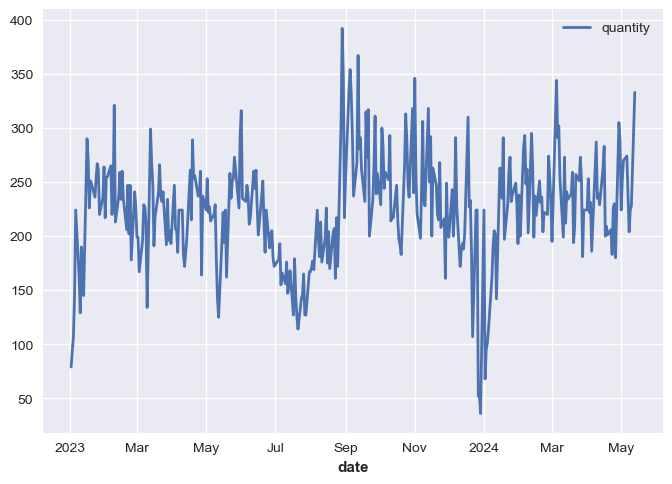

In [6]:
quantity_mean = df_hour12['quantity'].mean()
ts = TimeSeries.from_dataframe(df=df_hour12, time_col='date', value_cols='quantity', freq='B', fillna_value=quantity_mean)

ts.plot()

In [7]:
cutoff_date = pd.to_datetime('2024-02-01')
train, test = ts.split_before(cutoff_date)

<Axes: xlabel='date'>

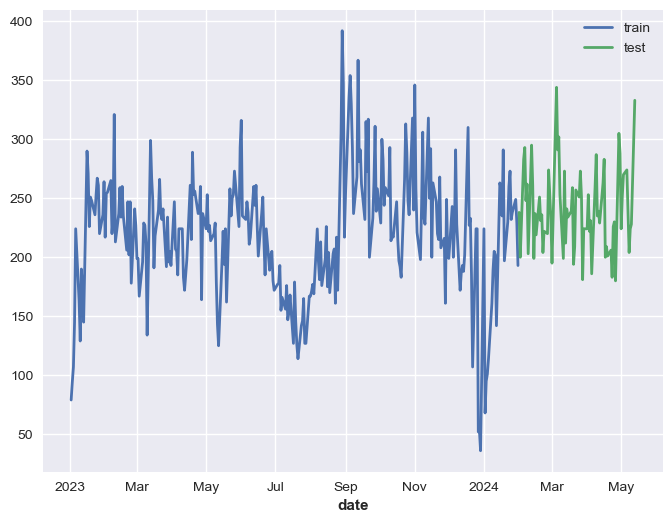

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')

In [77]:
def get_metrics(gt, pred) -> tuple:
    mse_score = mse(gt, pred)
    rmse_score = rmse(gt, pred)
    mae_score = mae(gt, pred)

    print(f"MSE : {mse_score:.5f}")
    print(f"RMSE: {rmse_score:.5f}")
    print(f"MAE : {mae_score:.5f}")

    return mse_score, rmse_score, mae_score

## Exponential Smoothing

MSE : 1210.45738
RMSE: 34.79163
MAE : 27.82762


<Axes: xlabel='date'>

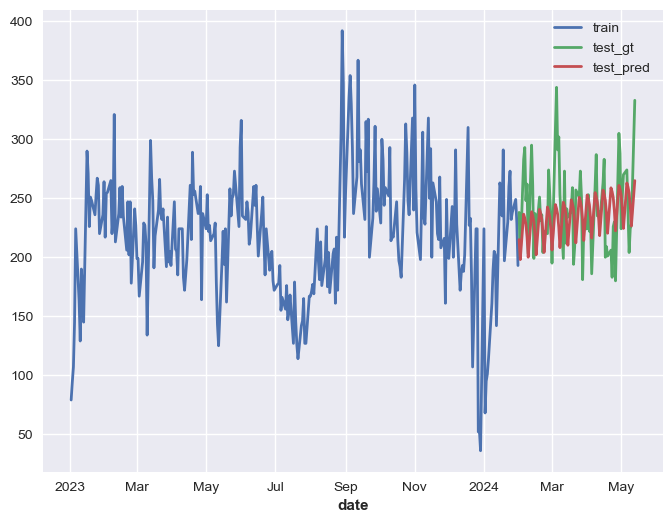

In [87]:
model = ExponentialSmoothing()

model.fit(train)
pred = model.predict(len(test))

get_metrics(test, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

MSE : 1482.14483
RMSE: 38.49863
MAE : 30.20147


<Axes: xlabel='date'>

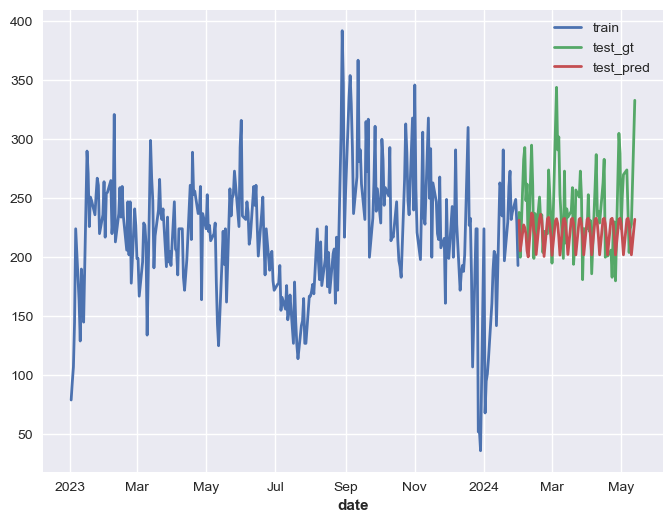

In [12]:
add_encoders = {
    'cyclic': {'future': ['dayofweek', 'hour']},
    'datetime_attribute': {'future': ['dayofweek']},
}


model = ARIMA(add_encoders=add_encoders)
model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

In [13]:
model.backtest(train_set)

/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

17.096796937918217

In [14]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

a = datetime_attribute_timeseries(train_set, "dayofweek", cyclic=True, add_length=len(test_set))

a

MSE : 1483.57615
RMSE: 38.51722
MAE : 30.21337


<Axes: xlabel='date'>

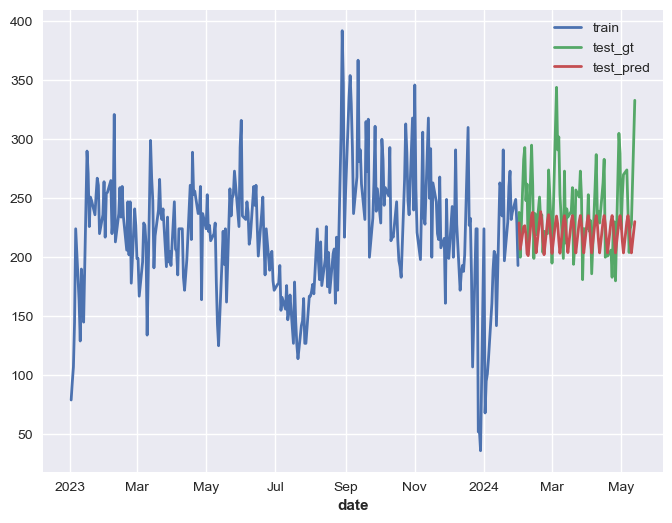

In [18]:
# add_encoders = {
#     'cyclic': {'future': ['dayofweek']},
#     'datetime_attribute': {'future': ['dayofweek']},
# }


model = ARIMA()
model.fit(train_set, future_covariates=a)
pred = model.predict(len(test_set), future_covariates=a)

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

In [21]:
from darts.dataprocessing.transformers import Diff

trans_diff = Diff(lags=7, dropna=True)
ts_diff = trans_diff.fit_transform(ts)

In [24]:
cutoff_date = pd.to_datetime('2024-02-01')
train_set, test_set = ts_diff.split_before(cutoff_date)

<Axes: xlabel='date'>

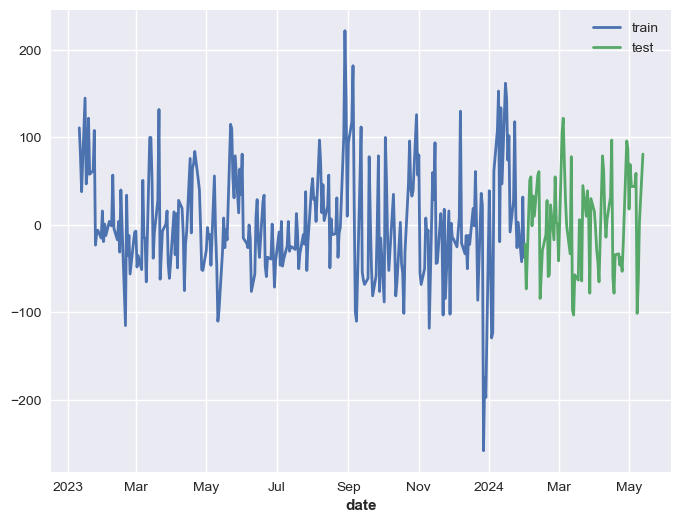

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test')

MSE : 2404.44847
RMSE: 49.03518
MAE : 40.51395


<Axes: xlabel='date'>

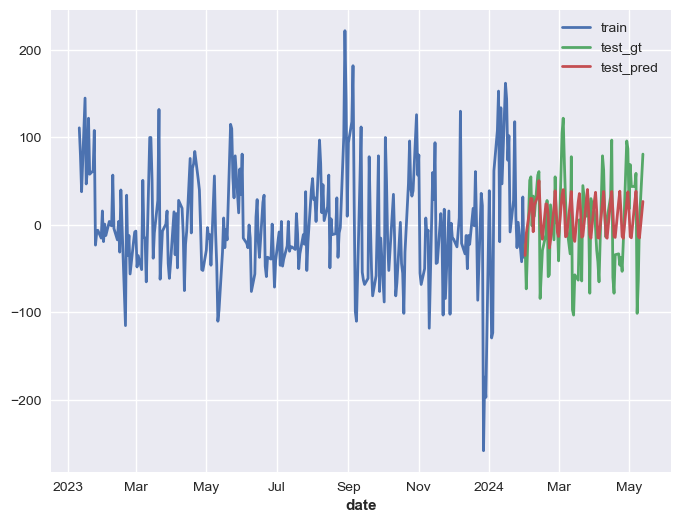

In [27]:
model = ExponentialSmoothing()

model.fit(train_set)
pred = model.predict(len(test_set))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

In [41]:
train_set, test_set = ts.split_before(cutoff_date)

In [37]:
ts_diff = trans_diff.inverse_transform(train_set.concatenate(pred))

_, test_pred = ts_diff.split_before(cutoff_date)

<Axes: xlabel='time'>

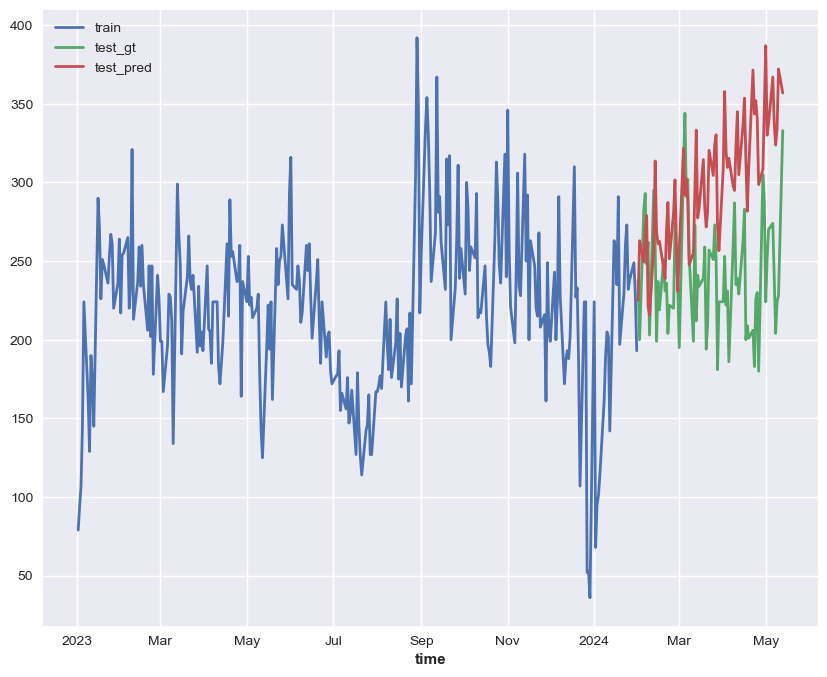

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label="test_gt")
test_pred.plot(ax=ax, label="test_pred")

## Test with log

<Axes: xlabel='date'>

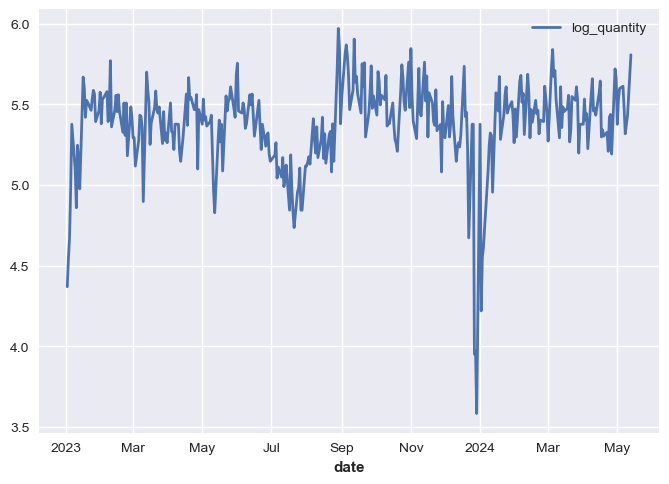

In [50]:
pd.options.mode.copy_on_write = True

df_hour12.loc[:, 'log_quantity'] = np.log(df_hour12['quantity'])

quantity_mean = df_hour12['log_quantity'].mean()
ts_log = TimeSeries.from_dataframe(df=df_hour12, time_col='date', value_cols='log_quantity', freq='B', fillna_value=quantity_mean)

ts_log.plot()

<Axes: xlabel='date'>

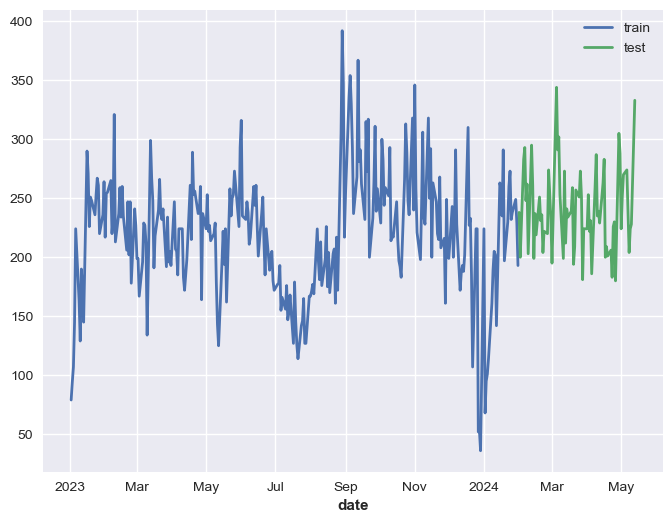

In [69]:
cutoff_date = pd.to_datetime('2024-02-01')

train, test = ts.split_before(cutoff_date)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')

## Create log version of train, test

In [66]:
train_log = TimeSeries.from_times_and_values(times=train.time_index, values=np.log(train.data_array()))
test_log = TimeSeries.from_times_and_values(times=test.time_index, values=np.log(test.data_array()))

MSE : 1326.85878
RMSE: 36.42607
MAE : 29.06901


<Axes: xlabel='date'>

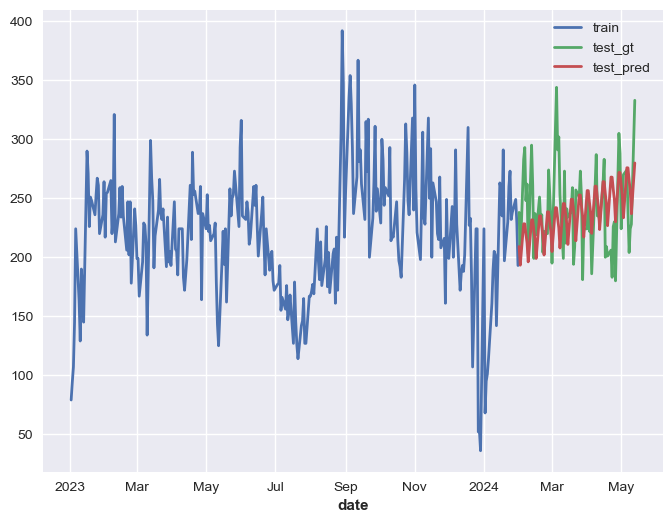

In [71]:
model = ExponentialSmoothing()

model.fit(train_log)

pred = model.predict(len(test_log))
test_pred = TimeSeries.from_times_and_values(times=test.time_index, values=np.exp(pred.data_array()))

get_metrics(test, test_pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE : 2526.44314
RMSE: 50.26374
MAE : 40.02505


/home/hoanghu/miniforge3/envs/py/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='date'>

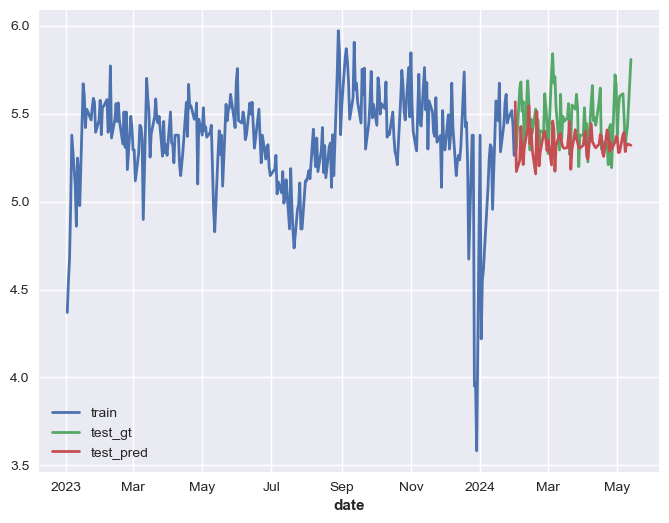

In [73]:
model = ARIMA(p=15, q=15)

model.fit(train_log)

pred = model.predict(len(test_log))
test_pred = TimeSeries.from_times_and_values(times=test.time_index, values=np.exp(pred.data_array()))

get_metrics(test, test_pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

## Compilation of naive models

MSE : 1780.51506
RMSE: 42.19615
MAE : 32.70950
MSE : 1311.94617
RMSE: 36.22080
MAE : 28.49504
MSE : 3661.46658
RMSE: 60.51005
MAE : 49.81463


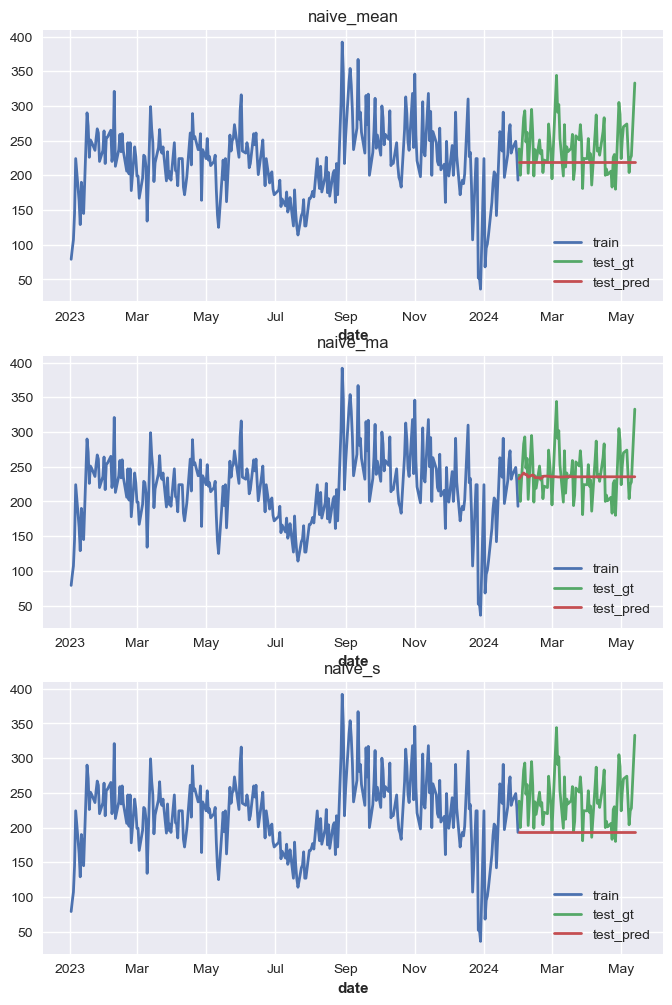

In [78]:
fig = plt.figure(figsize=(8, 12))
score_names = ['mse', 'rmse', 'mae']

models_naive = {
    'naive_mean' : NaiveMean(),
    'naive_ma' : NaiveMovingAverage(15),
    'naive_s' : NaiveSeasonal(K=1)
}

models_result = []


for i, (model_name, model) in enumerate(models_naive.items()):
    model.fit(train)

    test_pred = model.predict(len(test_log))

    for score_name, score in zip(score_names, get_metrics(test, test_pred)):
        models_result.append({
            'model': model_name,
            'score_name': score_name,
            'score': score    
        })

    
    ax = fig.add_subplot(3, 1, i+1)
    train.plot(ax=ax, label='train')
    test.plot(ax=ax, label='test_gt')
    test_pred.plot(ax=ax, label='test_pred')
    ax.set_title(model_name)

## KalmanFilter

MSE : 2237.72292
RMSE: 47.30458
MAE : 36.81032


<Axes: xlabel='date'>

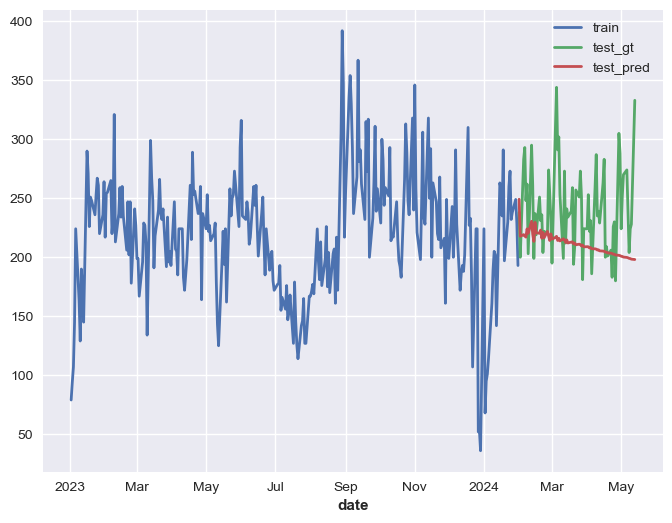

In [85]:
model_kf = KalmanForecaster(dim_x=15)

model_kf.fit(train)

test_pred = model_kf.predict(len(test))

get_metrics(test, test_pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

## Use scaler

In [90]:
trans_scaler = Scaler(MinMaxScaler())

In [91]:
ts_scaled = trans_scaler.fit_transform(ts)

In [92]:
train_scaled, test_scaled = ts_scaled.split_before(cutoff_date)

MSE : 1248.34616
RMSE: 35.33194
MAE : 28.28539


<Axes: xlabel='date'>

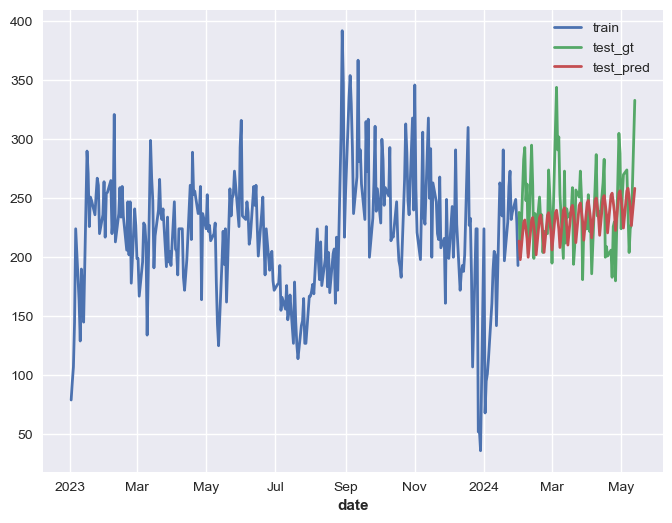

In [95]:
model = ExponentialSmoothing()

model.fit(train_scaled)
pred = model.predict(len(test))

test_pred = trans_scaler.inverse_transform(pred)

get_metrics(test, test_pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

## Use series from other hours as past covariate

In [96]:
df_hour11 = df_waste[df_waste['hour'] == 11]

fillna_val = 0
ts_hour11 = TimeSeries.from_dataframe(df=df_hour11, time_col='date', value_cols='quantity', freq='B', fillna_value=fillna_val)

covariate_past, _ = ts_hour11.split_before(cutoff_date)

In [ ]:
add_encoders = {
    'cyclic': {'future': ['dayofweek']},
    # 'datetime_attribute': {'future': ['dayofweek']},
}


model = ARIMA(add_encoders=add_encoders)
model.fit(train)
pred = model.predict(len(test))

get_metrics(test_set, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train_set.plot(ax=ax, label='train')
test_set.plot(ax=ax, label='test_gt')
pred.plot(ax=ax, label='test_pred')

# Time series with date and hour

In [ ]:
freq = pd.offsets.CustomBusinessHour(start="10:00", end="15:00", weekmask="Mon Tue Wed Thu Fri")
ts = TimeSeries.from_dataframe(df=df_waste, time_col='datetime', value_cols='quantity', freq=freq, fillna_value=0.)

cutoff_date = pd.to_datetime('2024-02-01')
train, test = ts.split_before(cutoff_date)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')

In [ ]:
add_encoders = {
    'cyclic': {
        'past': ['dayofweek', 'hour'],
        'future': ['dayofweek', 'hour'],
    },
    'datetime_attribute': {
        'future': ['hour', 'dayofweek'],
        'past': ['hour', 'dayofweek'],
    },
    # 'transformer': Diff(dropna=False),
}

In [ ]:
model = ARIMA(add_encoders=add_encoders)
model.fit(train)
pred = model.predict(len(test))
test_pred = pred

get_metrics(test, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

In [ ]:
model = XGBModel(
    lags=5,
    lags_past_covariates=5,
    # lags_future_covariates=[0,1,2,3,4,5],
    # output_chunk_length=1,
    add_encoders=add_encoders
)
model.fit(train)
pred = model.predict(len(test))
test_pred = pred

get_metrics(test, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

In [ ]:
model = LightGBMModel(
    lags=5,
    lags_past_covariates=5,
    # lags_future_covariates=[0,1,2,3,4,5],
    # output_chunk_length=1,
    add_encoders=add_encoders
)
model.fit(train)
pred = model.predict(len(test))
test_pred = pred

get_metrics(test, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')

In [ ]:
model = KalmanForecaster(
    add_encoders=add_encoders
)
model.fit(train)
pred = model.predict(len(test))
test_pred = pred

get_metrics(test, pred)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test_gt')
test_pred.plot(ax=ax, label='test_pred')